100%|██████████| 170M/170M [00:01<00:00, 104MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data

Starting annotation round 1...
Training model on labeled set with 1000 instances...
Validation accuracy after round 1: 11.40%, Average loss: 0.0185
Making predictions on unlabeled set with 44000 instances...
Selected 3 instances with lowest model confidence for annotation...
Requesting new labels...



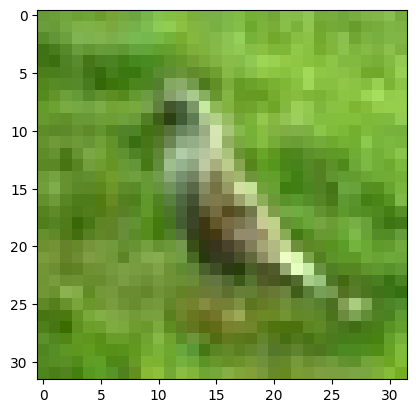

Model predicted label = 8
Ground truth label = 2
Please enter the label for this image (0-9): 2



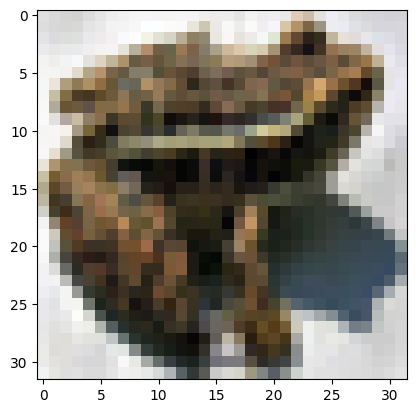

Model predicted label = 6
Ground truth label = 6
Please enter the label for this image (0-9): 3



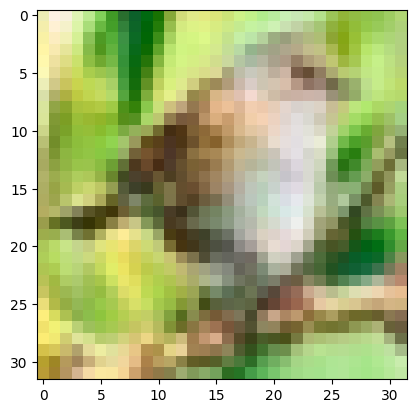

Model predicted label = 8
Ground truth label = 2
Please enter the label for this image (0-9): 4
Added 3 newly labeled instances to labeled set.
Removed newly labeled instances from unlabeled set. 43997 instances remaining.

Starting annotation round 2...
Training model on labeled set with 1003 instances...
Validation accuracy after round 2: 13.54%, Average loss: 0.0185
Making predictions on unlabeled set with 43997 instances...
Selected 3 instances with lowest model confidence for annotation...
Requesting new labels...



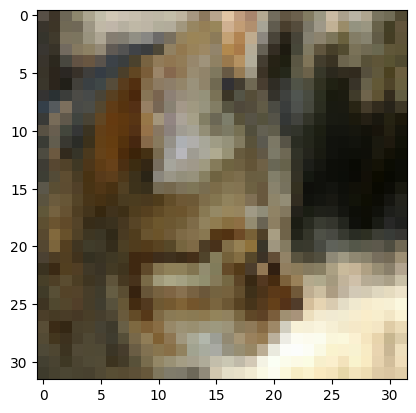

Model predicted label = 5
Ground truth label = 3
Please enter the label for this image (0-9): 4



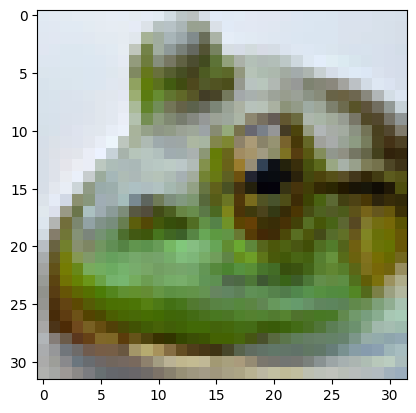

Model predicted label = 4
Ground truth label = 6
Please enter the label for this image (0-9): 3



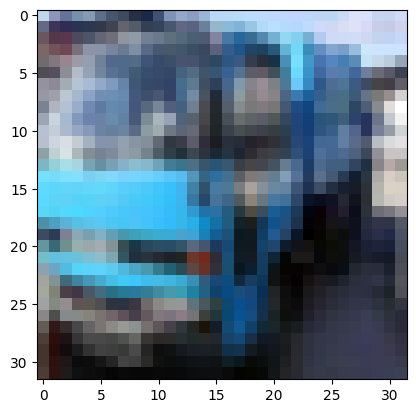

Model predicted label = 6
Ground truth label = 9
Please enter the label for this image (0-9): 2
Added 3 newly labeled instances to labeled set.
Removed newly labeled instances from unlabeled set. 43994 instances remaining.

Training model on final labeled set with 1006 instances...


Active learning process completed.
Final validation accuracy: 15.98%, Average loss: 0.0183


In [1]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader, random_split, Subset, ConcatDataset
import matplotlib.pyplot as plt
import numpy as np

# Выберите значение k, где первые k самых неопределенных прогнозов будут переименованы из человеческого ввода
least_confident_instances = 3
# Выберите количество раундов повторной маркировки + обучения
num_annotation_rounds = 2

# Загузим набор данных CIFAR-10
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Разделить набор данных на начальный маркированный набор, немаркированный набор и валидационный набор
labeled_set, remaining_set = random_split(dataset, [1000, len(dataset)-1000])
validation_set, unlabeled_set = random_split(remaining_set, [5000, len(remaining_set)-5000])

# Определите модель, функцию потерь и оптимизатор
model = torchvision.models.resnet18(num_classes=10)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

def train_model(model, dataloader, criterion, optimizer):
    model.train()
    for inputs, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

def evaluate_model(model, dataloader, criterion):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    avg_loss = total_loss / total
    return accuracy, avg_loss

def transform_image(image):
    image_min = np.min(image)
    image_max = np.max(image)
    transformed_image = (image - image_min) / (image_max - image_min)
    return transformed_image

def request_new_labels(unlabeled_set, model_predicted_labels, indices):
    new_labels = []
    valid_labels = list(range(10))  # CIFAR-10 имеет 10 классов
    for idx in indices:
        img, gt = unlabeled_set[idx]
        img = img.permute(1, 2, 0)
        print()
        plt.imshow(transform_image(img.numpy()))
        plt.show()
        print(f"Model predicted label = {model_predicted_labels[idx]}\nGround truth label = {gt}")
        while True:
            try:
                label = int(input("Please enter the label for this image (0-9): "))
                if label in valid_labels:
                    new_labels.append(label)
                    break
                else:
                    print("Invalid label. Please enter a number between 0 and 9.")
            except ValueError:
                print("Invalid input. Please enter a number between 0 and 9.")
    return torch.tensor(new_labels)

class LabeledDataset(torch.utils.data.Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __getitem__(self, index):
        return self.data[index], self.targets[index]

    def __len__(self):
        return len(self.data)

for iteration in range(num_annotation_rounds):
    print(f"\nStarting annotation round {iteration + 1}...")

    dataloader = DataLoader(labeled_set, batch_size=128, shuffle=True)
    print(f"Training model on labeled set with {len(labeled_set)} instances...")
    train_model(model, dataloader, criterion, optimizer)

    validation_loader = DataLoader(validation_set, batch_size=128, shuffle=False)
    accuracy, avg_loss = evaluate_model(model, validation_loader, criterion)
    print(f"Validation accuracy after round {iteration + 1}: {accuracy:.2f}%, Average loss: {avg_loss:.4f}")

    dataloader = DataLoader(unlabeled_set, batch_size=128)
    predictions = []
    print(f"Making predictions on unlabeled set with {len(unlabeled_set)} instances...")
    with torch.no_grad():
        for i, (inputs, _) in enumerate(dataloader):
            outputs = model(inputs)
            predictions.extend(outputs.softmax(dim=-1))
            if i == 3:
                break

    predictions_matrix = torch.stack(predictions)
    probabilities, model_predicted_labels = torch.max(predictions_matrix, dim=1)
    uncertainty_scores = 1.0 - probabilities
    _, indices = torch.topk(uncertainty_scores, k=least_confident_instances)
    print(f"Selected {len(indices)} instances with lowest model confidence for annotation...")

    print("Requesting new labels...")
    new_labels = request_new_labels(unlabeled_set, model_predicted_labels, indices)

    new_data = [unlabeled_set[i][0] for i in indices.tolist()]
    new_labeled_set = LabeledDataset(new_data, new_labels)
    labeled_set = ConcatDataset([labeled_set, new_labeled_set])
    print(f"Added {len(new_labeled_set)} newly labeled instances to labeled set.")
    unlabeled_set = Subset(unlabeled_set, list(set(range(len(unlabeled_set))) - set(indices.tolist())))
    print(f"Removed newly labeled instances from unlabeled set. {len(unlabeled_set)} instances remaining.")

dataloader = DataLoader(labeled_set, batch_size=128, shuffle=True)
print(f"\nTraining model on final labeled set with {len(labeled_set)} instances...")
train_model(model, dataloader, criterion, optimizer)
print("\n\nActive learning process completed.")

# Оценка окончательной модели
validation_loader = DataLoader(validation_set, batch_size=128, shuffle=False)
final_accuracy, final_avg_loss = evaluate_model(model, validation_loader, criterion)
print(f"Final validation accuracy: {final_accuracy:.2f}%, Average loss: {final_avg_loss:.4f}")
